# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: November, 2025

**Student Name**: Sergio Villa Rodriguez

**Professor**: Pablo Camarillo Ramirez

# Create Spark Session

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (files)") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/24 00:58:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Create data stream

## Execute script

python3 /opt/spark/work-dir/lib/sergiovillaa/streaming_producer.py

## Define schema

In [2]:
from sergiovillaa.spark_utils import SparkUtils

columns_schema = [('user_id', 'string'),
                  ('session_id', 'string'),
                  ('device_id', 'int'),
                  ('match_id', 'int'), # match/game/event id
                  ('duration_watched', 'double'), 
                  ('genre', 'string'), #irrelevant
                  ('country', 'string'), #irrelevant
                  ('age', 'int'), #irrelevant
                  ('gender', 'string'), #irrelevant
                  ('subscription_type', 'string')]

schema = SparkUtils.generate_schema(columns_schema)

## Read stream

In [3]:
df = spark.readStream \
            .format("csv") \
            .schema(schema) \
            .load("/opt/spark/work-dir/final_project/incoming_data")

## Transformations

In [4]:
from pyspark.sql.functions import when, lit, col, avg, min, max

# Eliminating columns that are not useful to simulate Caliente TV
df_t1 = df.drop('genre', 'country', 'age', 'gender')
# Dropping nulls
df_t2 = df_t1.dropna()
# New column subscription type numeric
df_t3 = df_t2.withColumn('subscription_numeric',
                         when(df_t2.subscription_type == 'Premium', lit(1))
                        .when(df_t2.subscription_type == 'Free', lit(0)))

# Persistence data

In [5]:
query = df_t3.writeStream \
             .format("csv") \
             .option("path", "/opt/spark/work-dir/final_project/data_output") \
             .option("checkpointLocation", "/opt/spark/work-dir/final_project/checkpoints") \
             .outputMode("append") \
             .start()

query.awaitTermination(30)

False

# Power BI

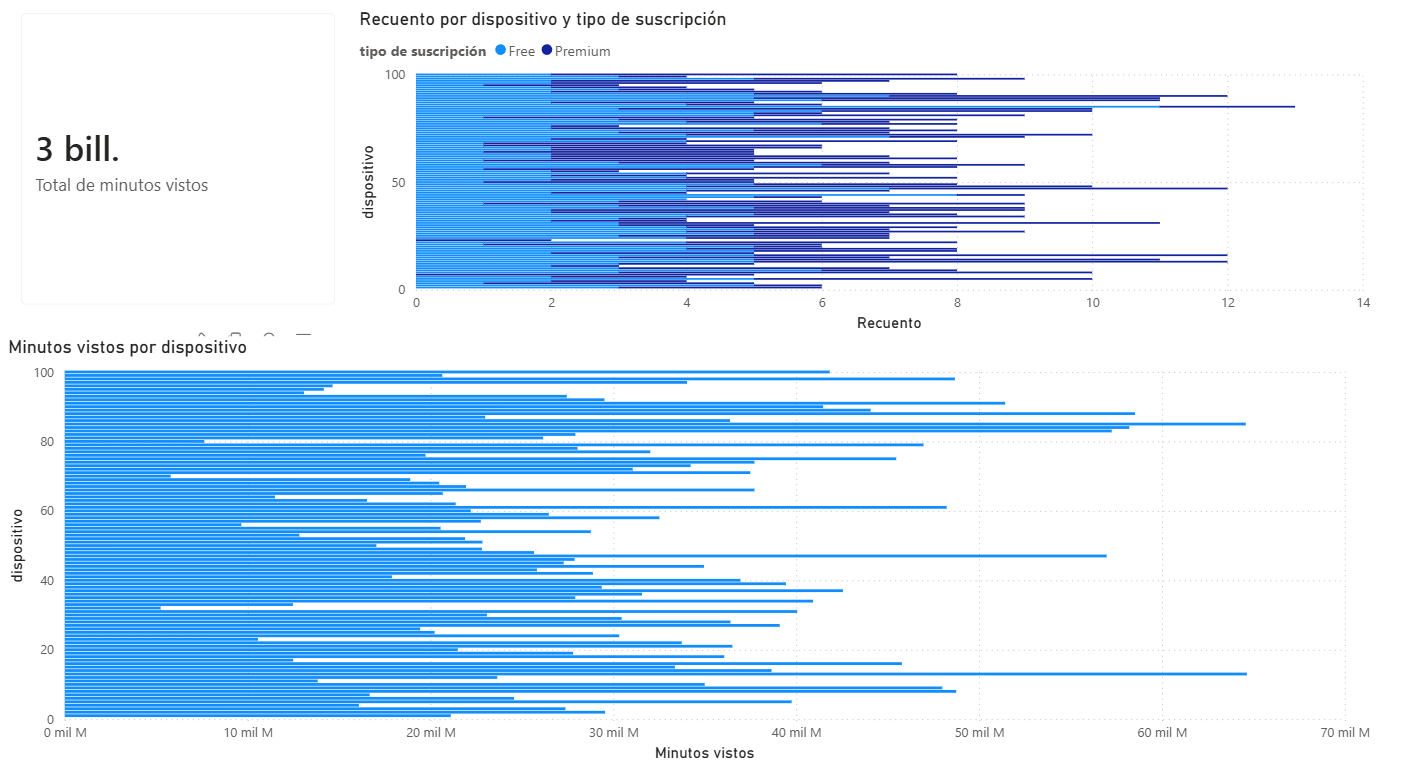

In [6]:
sc.stop()